In [1]:
import pandas as pd
df = pd.DataFrame()
import csv
from scipy.stats import zscore
import numpy as np
import datetime as dt

### Input data that can't be extracted

In [4]:
# log month represents the month in the log file: 1 = January, 2 = February, etc.
log_month = 9
# log day represents the day in the log file: 1 = 1st, 2 = 2nd, etc.
log_day = 21
# log year represents the year in the log file: 2018, 2019, etc.
log_year = 2021




### do not change below this line ###
# Calcuate the day name of the date
log_day_name = dt.datetime(log_year, log_month, log_day)
log_day_name = log_day_name.strftime("%A")
log_date = f'{log_month}_{log_day}_{log_year}'
file_name = log_date + '_raw.csv'
print(log_day_name)
### do not change above line ###


Tuesday


## Extract data from raw text wifi log file

In [5]:
#Create csv file
raw_csv = open(file_name, 'w+')
#Column names
col_name = ['building', 'time', 'device_count']
csv_writer = csv.DictWriter(raw_csv, fieldnames=col_name)
csv_writer.writeheader()

28

In [6]:
def processLine(buildingName='UREC', wifi_log=''):
    count = 0
    for log_line in wifi_log:
        if buildingName in log_line:
            # process device count
            if '501080' in log_line or '501105' in log_line or '501106' in log_line:
                count += 0
            if '501093' in log_line:
                count += 1
            # Slice the line to get the date and time
            atr = log_line.split(' ')
            # Extract the data
            # month = 0
            # day = 0
            # day_name = ''
            time = atr[2]
            building = buildingName
            # add data to csv file
            csv_writer.writerow({'building': building,'time': time, 'device_count': count})


In [7]:
wifi_log = open('wireless_09-21-2021.log', 'r')
# # print first ten lines in the file
# for i in range(3):
#     print(wifi_log.readline())

# loop through each line in the file
processLine(wifi_log=wifi_log)

# close the file
wifi_log.close()


# Preprocess the raw csv to something meaningful (non-scalable)

### Look at the dataframe

In [8]:
# Look look at the data
# convert file_name.csv to dataframe
df = pd.read_csv(file_name)
df

,building,time,device_count
0,UREC,00:00:11,1
1,UREC,00:00:11,1
2,UREC,00:00:11,1
3,UREC,00:00:11,1
4,UREC,00:00:11,1
...,...,...,...
1056851,UREC,23:42:06,172645
1056852,UREC,23:42:11,172646
1056853,UREC,23:42:11,172646
1056854,UREC,23:42:11,172646


### Process the day_name, to reflect the data properly

In [9]:
df['day_name'] = log_day_name
df['month'] = log_month
df['day'] = log_day
df['year'] = log_year
df

,building,time,device_count,day_name,month,day,year
0,UREC,00:00:11,1,Tuesday,9,21,2021
1,UREC,00:00:11,1,Tuesday,9,21,2021
2,UREC,00:00:11,1,Tuesday,9,21,2021
3,UREC,00:00:11,1,Tuesday,9,21,2021
4,UREC,00:00:11,1,Tuesday,9,21,2021
...,...,...,...,...,...,...,...
1056851,UREC,23:42:06,172645,Tuesday,9,21,2021
1056852,UREC,23:42:11,172646,Tuesday,9,21,2021
1056853,UREC,23:42:11,172646,Tuesday,9,21,2021
1056854,UREC,23:42:11,172646,Tuesday,9,21,2021


### Process the time columns into a timestamp column

In [10]:
# convert time, day, month, year to datetime
df['timestamp']=df[['year','month','day']].astype(str).apply('-'.join,1)+' '+df['time']
df['timestamp'] = pd.to_datetime(df['timestamp'])
# df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'time']])
# get type of time column
print('timestamp column type: ', df['timestamp'].dtype)
df

timestamp column type:  datetime64[ns]


,building,time,device_count,day_name,month,day,year,timestamp
0,UREC,00:00:11,1,Tuesday,9,21,2021,2021-09-21 00:00:11
1,UREC,00:00:11,1,Tuesday,9,21,2021,2021-09-21 00:00:11
2,UREC,00:00:11,1,Tuesday,9,21,2021,2021-09-21 00:00:11
3,UREC,00:00:11,1,Tuesday,9,21,2021,2021-09-21 00:00:11
4,UREC,00:00:11,1,Tuesday,9,21,2021,2021-09-21 00:00:11
...,...,...,...,...,...,...,...,...
1056851,UREC,23:42:06,172645,Tuesday,9,21,2021,2021-09-21 23:42:06
1056852,UREC,23:42:11,172646,Tuesday,9,21,2021,2021-09-21 23:42:11
1056853,UREC,23:42:11,172646,Tuesday,9,21,2021,2021-09-21 23:42:11
1056854,UREC,23:42:11,172646,Tuesday,9,21,2021,2021-09-21 23:42:11


In [116]:
# testing
# query the row between 00:00:00 and 00:00:59
# df.query('timestamp >= "2021-09-20 00:00:00" and timestamp <= "2021-09-20 00:00:59"')

In [11]:
count = 0
dfTrim = pd.DataFrame()
df1 = pd.DataFrame()

while count < 24:
    startTime = ''
    endTime = ''

    if count < 10:
        # add log_day, log_month, log_year, and time to the start and end time
        startTime = str(log_year) + '-' + str(log_month) + '-' + str(log_day) + ' 0' + str(count) + ':00:00'
        startTime= pd.to_datetime(startTime)
        endTime = str(log_year) + '-' + str(log_month) + '-' + str(log_day) + ' 0' + str(count) + ':59:59'
        endTime = pd.to_datetime(endTime)
    else:
        startTime = str(log_year) + '-' + str(log_month) + '-' + str(log_day) + ' ' + str(count) + ':00:00'
        startTime= pd.to_datetime(startTime)
        endTime = str(log_year) + '-' + str(log_month) + '-' + str(log_day) + ' ' + str(count) + ':59:59'
        endTime = pd.to_datetime(endTime)
    # loc the rows between the start and end time
    df1 = df.loc[(df['timestamp'] >= startTime) & (df['timestamp'] <= endTime)]
    # contact the first row of df1 to dfTrim
    dfTrim = pd.concat([dfTrim, df1.head(1)])
    count += 1


dfTrim = dfTrim.reset_index()
dfTrim


,index,building,time,device_count,day_name,month,day,year,timestamp
0,0,UREC,00:00:11,1,Tuesday,9,21,2021,2021-09-21 00:00:11
1,1499,UREC,01:00:08,250,Tuesday,9,21,2021,2021-09-21 01:00:08
2,3257,UREC,02:00:03,542,Tuesday,9,21,2021,2021-09-21 02:00:03
3,3787,UREC,03:00:02,629,Tuesday,9,21,2021,2021-09-21 03:00:02
4,4222,UREC,04:00:23,700,Tuesday,9,21,2021,2021-09-21 04:00:23
5,4548,UREC,05:00:09,751,Tuesday,9,21,2021,2021-09-21 05:00:09
6,6762,UREC,06:00:02,1121,Tuesday,9,21,2021,2021-09-21 06:00:02
7,23776,UREC,07:00:00,3795,Tuesday,9,21,2021,2021-09-21 07:00:00
8,52629,UREC,08:00:00,8342,Tuesday,9,21,2021,2021-09-21 08:00:00
9,93891,UREC,09:00:00,15083,Tuesday,9,21,2021,2021-09-21 09:00:00


In [12]:
dfTrim['traffic_diff'] = dfTrim['device_count'].diff(periods=1)
dfTrim

,index,building,time,device_count,day_name,month,day,year,timestamp,traffic_diff
0,0,UREC,00:00:11,1,Tuesday,9,21,2021,2021-09-21 00:00:11,NaN
1,1499,UREC,01:00:08,250,Tuesday,9,21,2021,2021-09-21 01:00:08,249.0
2,3257,UREC,02:00:03,542,Tuesday,9,21,2021,2021-09-21 02:00:03,292.0
3,3787,UREC,03:00:02,629,Tuesday,9,21,2021,2021-09-21 03:00:02,87.0
4,4222,UREC,04:00:23,700,Tuesday,9,21,2021,2021-09-21 04:00:23,71.0
5,4548,UREC,05:00:09,751,Tuesday,9,21,2021,2021-09-21 05:00:09,51.0
6,6762,UREC,06:00:02,1121,Tuesday,9,21,2021,2021-09-21 06:00:02,370.0
7,23776,UREC,07:00:00,3795,Tuesday,9,21,2021,2021-09-21 07:00:00,2674.0
8,52629,UREC,08:00:00,8342,Tuesday,9,21,2021,2021-09-21 08:00:00,4547.0
9,93891,UREC,09:00:00,15083,Tuesday,9,21,2021,2021-09-21 09:00:00,6741.0


In [13]:
dfTrim['traffic_diff'] = dfTrim['traffic_diff'].replace(np.nan, 0)
dfTrim['traffic_diff_zscore'] = zscore(dfTrim['traffic_diff'])
print(dfTrim['traffic_diff'].dtype)
dfTrim

float64


,index,building,time,device_count,day_name,month,day,year,timestamp,traffic_diff,traffic_diff_zscore
0,0,UREC,00:00:11,1,Tuesday,9,21,2021,2021-09-21 00:00:11,0.0,-1.305164
1,1499,UREC,01:00:08,250,Tuesday,9,21,2021,2021-09-21 01:00:08,249.0,-1.259739
2,3257,UREC,02:00:03,542,Tuesday,9,21,2021,2021-09-21 02:00:03,292.0,-1.251894
3,3787,UREC,03:00:02,629,Tuesday,9,21,2021,2021-09-21 03:00:02,87.0,-1.289293
4,4222,UREC,04:00:23,700,Tuesday,9,21,2021,2021-09-21 04:00:23,71.0,-1.292212
5,4548,UREC,05:00:09,751,Tuesday,9,21,2021,2021-09-21 05:00:09,51.0,-1.295860
6,6762,UREC,06:00:02,1121,Tuesday,9,21,2021,2021-09-21 06:00:02,370.0,-1.237665
7,23776,UREC,07:00:00,3795,Tuesday,9,21,2021,2021-09-21 07:00:00,2674.0,-0.817344
8,52629,UREC,08:00:00,8342,Tuesday,9,21,2021,2021-09-21 08:00:00,4547.0,-0.475651
9,93891,UREC,09:00:00,15083,Tuesday,9,21,2021,2021-09-21 09:00:00,6741.0,-0.075397


In [14]:
# add hours as new column
dfTrim['index_hour'] = dfTrim.index
dfTrim

,index,building,time,device_count,day_name,month,day,year,timestamp,traffic_diff,traffic_diff_zscore,index_hour
0,0,UREC,00:00:11,1,Tuesday,9,21,2021,2021-09-21 00:00:11,0.0,-1.305164,0
1,1499,UREC,01:00:08,250,Tuesday,9,21,2021,2021-09-21 01:00:08,249.0,-1.259739,1
2,3257,UREC,02:00:03,542,Tuesday,9,21,2021,2021-09-21 02:00:03,292.0,-1.251894,2
3,3787,UREC,03:00:02,629,Tuesday,9,21,2021,2021-09-21 03:00:02,87.0,-1.289293,3
4,4222,UREC,04:00:23,700,Tuesday,9,21,2021,2021-09-21 04:00:23,71.0,-1.292212,4
5,4548,UREC,05:00:09,751,Tuesday,9,21,2021,2021-09-21 05:00:09,51.0,-1.295860,5
6,6762,UREC,06:00:02,1121,Tuesday,9,21,2021,2021-09-21 06:00:02,370.0,-1.237665,6
7,23776,UREC,07:00:00,3795,Tuesday,9,21,2021,2021-09-21 07:00:00,2674.0,-0.817344,7
8,52629,UREC,08:00:00,8342,Tuesday,9,21,2021,2021-09-21 08:00:00,4547.0,-0.475651,8
9,93891,UREC,09:00:00,15083,Tuesday,9,21,2021,2021-09-21 09:00:00,6741.0,-0.075397,9


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

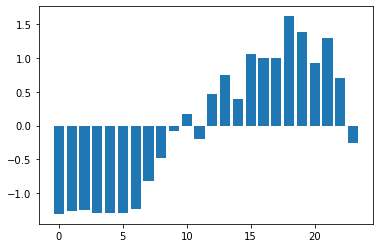

In [16]:
# bar graph
plt.bar(dfTrim.index, dfTrim['traffic_diff_zscore'])
plt.show()

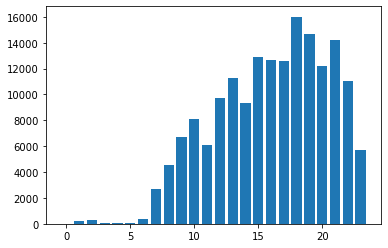

In [17]:
# bar graph
plt.bar(dfTrim.index, dfTrim['traffic_diff'])
plt.show()

In [20]:
# create list of days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# create list from 0 to 23
hours = list(range(0, 24))
# create heatmap with days as y-axis and hours as x-axis
dfTrim = dfTrim.pivot('day_name', 'index_hour', 'traffic_diff_zscore')
# sns.heatmap(dfTrim, xticklabels=days, yticklabels=hours)

KeyError: 'day_name'

<AxesSubplot:xlabel='index_hour', ylabel='day_name'>

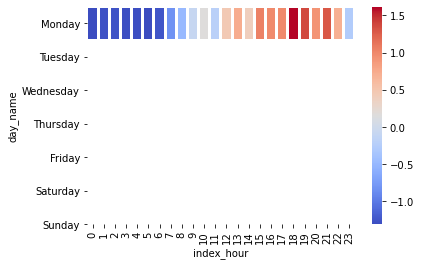

In [21]:
sns.heatmap(dfTrim, yticklabels=days, xticklabels=hours,linewidth = 2, cmap='coolwarm')